# Final Project: Case Study in Recognition of Emotion from Speech
## Related specifically to Text only


## Importing packages

In [1]:
#Importing the necessary packages
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%matplotlib inline
import urllib.request
import numpy as np
import pandas as pd
import sys
import os
import nltk
import gensim
from gensim.utils import tokenize
from gensim.models import Word2Vec
import re
from nltk.corpus import stopwords
import sklearn
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import model_from_json
from keras import optimizers
from keras import regularizers

c:\users\turia\anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
c:\users\turia\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Preprocessing

### Loading and Trimming the Dataset:

In [2]:
#Read the dataset into a pandas data frame
senti = pd.read_csv("./Twitter-sentiment-self-drive-DFE-dataset.csv")
print('Dimensions of the Dataframe:', senti.shape)

Dimensions of the Dataframe: (7156, 11)


In [3]:
pd.options.display.max_colwidth = 2000

senti[:12]

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,our_id,sentiment_gold,sentiment_gold_reason,text
0,724227031,True,golden,236,NaN,5,0.7579,10001,5\n4,Author is excited about the development of the technology.,Two places I'd invest all my money if I could: 3D printing and Self-driving cars!!!
1,724227032,True,golden,231,NaN,5,0.8775,10002,5\n4,Author is excited that driverless cars will benefit the disabled.,Awesome! Google driverless cars will help the blind travel more often; https://t.co/QWuXR0FrBpv
2,724227033,True,golden,233,NaN,2,0.6805,10003,2\n1,The author is skeptical of the safety and reliability of a driverless car.,"If Google maps can't keep up with road construction, how am I supposed to trust a driverless car to get around here?"
3,724227034,True,golden,240,NaN,2,0.8820,10004,2\n1,The author is skeptical of the project's value.,Autonomous cars seem way overhyped given the technology challenges; pilotless planes seem much more doable and needed.
4,724227035,True,golden,240,NaN,3,1.0000,10005,3,Author is making an observation without expressing an opinion.,Just saw Google self-driving car on I-34. It was painted green and blue.
5,724227036,True,golden,241,NaN,3,1.0000,10006,3,Author is asking a question without expressing an opinion.,Will driverless cars eventually replace taxi drivers in cities?
6,724227037,True,golden,226,NaN,not_relevant,0.5367,10007,not_relevant,Trains (metros) are not relevant to the focus of this project. Please re-read the instructions.,Chicago metro expected to be fully autonomous by 2020
7,724227038,True,golden,241,NaN,not_relevant,0.6548,10008,not_relevant,Author is not referring to self-driving cars. Please re-read the instructions.,I love the infotainment system in my new car. This thing can almost drive itself.
8,724227039,True,golden,238,NaN,5,0.7187,10009,5\n4,Shows excitement that autonomous vehicles will improve safety,Autonomous vehicles could reduce traffic fatalities by 90%...I'm in!
9,724227040,True,golden,230,NaN,1,0.6412,10010,2\n1,Shows fear that driverless cars will not be safe or reliable,Driverless cars are not worth the risk. Don't want to be on the highway when the server crashes #SadMacFace #BlueScreenofDeath


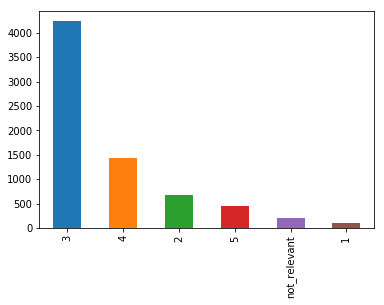

In [4]:
#Print the frequency of values in the sentiment column
fig, ax = plt.subplots()
senti['sentiment'].value_counts().plot(ax=ax, kind='bar')

In [5]:
#Drop the columns that are unnecessary for solving the problem
senti = senti.drop(['_unit_id', '_golden', '_unit_state', '_trusted_judgments', '_last_judgment_at', 'sentiment:confidence', 'our_id', 'sentiment_gold', 'sentiment_gold_reason'], axis=1)

In [6]:
#Remove NaN values, which are called 'not_relevant' in this dataset
senti = senti[senti.sentiment != 'not_relevant']
senti

,sentiment,text
0,5,Two places I'd invest all my money if I could: 3D printing and Self-driving cars!!!
1,5,Awesome! Google driverless cars will help the blind travel more often; https://t.co/QWuXR0FrBpv
2,2,"If Google maps can't keep up with road construction, how am I supposed to trust a driverless car to get around here?"
3,2,Autonomous cars seem way overhyped given the technology challenges; pilotless planes seem much more doable and needed.
4,3,Just saw Google self-driving car on I-34. It was painted green and blue.
5,3,Will driverless cars eventually replace taxi drivers in cities?
8,5,Autonomous vehicles could reduce traffic fatalities by 90%...I'm in!
9,1,Driverless cars are not worth the risk. Don't want to be on the highway when the server crashes #SadMacFace #BlueScreenofDeath
10,3,"Driverless cars are now legal in Florida, California, and Michigan"
11,3,Audi is the first carmaker to get a license from Nevada DMV to test automated vehicles. #audi #ces #cartech


In [7]:
#Resetting the index of the dataframe to reflect the modified dataset
senti = senti.reset_index(drop=True)

In [8]:
senti[:13]

,sentiment,text
0,5,Two places I'd invest all my money if I could: 3D printing and Self-driving cars!!!
1,5,Awesome! Google driverless cars will help the blind travel more often; https://t.co/QWuXR0FrBpv
2,2,"If Google maps can't keep up with road construction, how am I supposed to trust a driverless car to get around here?"
3,2,Autonomous cars seem way overhyped given the technology challenges; pilotless planes seem much more doable and needed.
4,3,Just saw Google self-driving car on I-34. It was painted green and blue.
5,3,Will driverless cars eventually replace taxi drivers in cities?
6,5,Autonomous vehicles could reduce traffic fatalities by 90%...I'm in!
7,1,Driverless cars are not worth the risk. Don't want to be on the highway when the server crashes #SadMacFace #BlueScreenofDeath
8,3,"Driverless cars are now legal in Florida, California, and Michigan"
9,3,Audi is the first carmaker to get a license from Nevada DMV to test automated vehicles. #audi #ces #cartech


In [9]:
#The rows and columns of the dataset
senti.shape

(6943, 2)

In [10]:
text_col = senti.text
text_col

0                                                                                     Two places I'd invest all my money if I could: 3D printing and Self-driving cars!!!
1                                                                         Awesome! Google driverless cars will help the blind travel more often; https://t.co/QWuXR0FrBpv
2                                                    If Google maps can't keep up with road construction, how am I supposed to trust a driverless car to get around here?
3                                                  Autonomous cars seem way overhyped given the technology challenges; pilotless planes seem much more doable and needed.
4                                                                                                Just saw Google self-driving car on I-34. It was painted green and blue.
5                                                                                                         Will driverless cars eventually replace taxi

In [11]:
#Making the characters lowercase
text_col = text_col.str.lower()

In [13]:
#Removing the URL Links with a regular expresion.
text_col = text_col.replace(r'((www\.[^\s]+)|(https?://[^\s]+))', '', regex=True)
#Removing the @username Links with a regular expresion.
text_col = text_col.replace('@[^\s]+', '', regex=True)
#Some tweets involve the use of the at (@) symbol, whitespace, and then a word, such as: @ Trapack dock
#Here we are removing the @ username Links with a regular expresion.
text_col = text_col.replace('@ [^\s]+', '', regex=True)
#Replacing the #Links with a regular expresion.
text_col = text_col.replace(r'#([^\s]+)', r'\1', regex=True)

In [14]:
#Removing additional whitespaces
text_col = text_col.replace('[\s]+', ' ', regex=True)
#Remove all digits
text_col = text_col.replace(r'\w*\d\w*', '', regex=True)

In [15]:
#Expanding contractions 
#(code taken from https://stackoverflow.com/questions/43018030/replace-appostrophe-short-words-in-python/47091370#47091370)
text_col = text_col.replace(r"won't", "will not", regex=True)
text_col = text_col.replace(r"can\'t", "can not", regex=True)
text_col = text_col.replace(r"n\'t", " not", regex=True)
text_col = text_col.replace(r"\'re", " are", regex=True)
text_col = text_col.replace(r"\'s", " is", regex=True)
text_col = text_col.replace(r"\'d", " would", regex=True)
text_col = text_col.replace(r"\'ll", " will", regex=True)
text_col = text_col.replace(r"\'t", " not", regex=True)
text_col = text_col.replace(r"\'ve", " have", regex=True)
text_col = text_col.replace(r"\'m", " am", regex=True)
text_col

0                                                            two places i would invest all my money if i could:  printing and self-driving cars!!!
1                                                                          awesome! google driverless cars will help the blind travel more often; 
2                           if google maps can not keep up with road construction, how am i supposed to trust a driverless car to get around here?
3                           autonomous cars seem way overhyped given the technology challenges; pilotless planes seem much more doable and needed.
4                                                                           just saw google self-driving car on i-. it was painted green and blue.
5                                                                                  will driverless cars eventually replace taxi drivers in cities?
6                                                                              autonomous vehicles could reduce traffi

In [16]:
#Removing special Characters
text_col = text_col.replace('([^\s\w-]|_)+', "", regex=True)
text_col = text_col.replace('ì|¡||ü|è|ï|å|ã|_|ì|±|¢|‰|â|å||Ì|¢|‰|Â|Ò|ò|û|ª', " ", regex=True)
text_col = text_col.replace('-', " ", regex=True)
text_col

0                                                              two places i would invest all my money if i could  printing and self driving cars
1                                                                          awesome google driverless cars will help the blind travel more often 
2                           if google maps can not keep up with road construction how am i supposed to trust a driverless car to get around here
3                           autonomous cars seem way overhyped given the technology challenges pilotless planes seem much more doable and needed
4                                                                           just saw google self driving car on i  it was painted green and blue
5                                                                                 will driverless cars eventually replace taxi drivers in cities
6                                                                                 autonomous vehicles could reduce traffic fatalit

In [17]:
#Now, let's remove stopwords using NLTK
#Here, I am printing the list of stop words, so I know what stop words I should remove for the sentiment analysis problem
set(stopwords.words('english'))

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [18]:
#Here, I am removing the "not", "nor", and "no" stopwords from NLTK's stopwords set
stop_words = set(stopwords.words('english')) - {"nor", "not", "no"} 
#Here, I am removing the stopwords from the text
stopwords_re = re.compile(r"(\s+)?\b({})\b(\s+)?".format("|".join(stop_words), re.IGNORECASE))
#Here, I am adjusting the whitespace accordingly
whitespace_re = re.compile(r"\s+")
text_col = text_col.replace(stopwords_re, " ").str.strip().str.replace(whitespace_re, " ")

### Generate Word2Vec embeddings

In [20]:
#First, I will make sure that the dataset has been pre-processed correctly.
senti.text = text_col
senti[:18]

,sentiment,text
0,5,two places would invest money could printing self driving cars
1,5,awesome google driverless cars help blind travel often
2,2,google maps not keep road construction supposed trust driverless car get around
3,2,autonomous cars seem way overhyped given technology challenges pilotless planes seem much doable needed
4,3,saw google self driving car painted green blue
5,3,driverless cars eventually replace taxi drivers cities
6,5,autonomous vehicles could reduce traffic fatalities
7,1,driverless cars not worth risk not want highway server crashes sadmacface bluescreenofdeath
8,3,driverless cars legal florida california michigan
9,3,audi first carmaker get license nevada dmv test automated vehicles audi ces cartech


In [21]:
#Here, I am using gensim.util's tokenizer to tokenize the text, and I am using a for loop to append the tokens to an array.
array = []
for i in range(0, len(senti.text)):
    hello = list(tokenize(senti.text[i]))
    array.append(hello)

In [22]:
print(array)

[['two', 'places', 'would', 'invest', 'money', 'could', 'printing', 'self', 'driving', 'cars'], ['awesome', 'google', 'driverless', 'cars', 'help', 'blind', 'travel', 'often'], ['google', 'maps', 'not', 'keep', 'road', 'construction', 'supposed', 'trust', 'driverless', 'car', 'get', 'around'], ['autonomous', 'cars', 'seem', 'way', 'overhyped', 'given', 'technology', 'challenges', 'pilotless', 'planes', 'seem', 'much', 'doable', 'needed'], ['saw', 'google', 'self', 'driving', 'car', 'painted', 'green', 'blue'], ['driverless', 'cars', 'eventually', 'replace', 'taxi', 'drivers', 'cities'], ['autonomous', 'vehicles', 'could', 'reduce', 'traffic', 'fatalities'], ['driverless', 'cars', 'not', 'worth', 'risk', 'not', 'want', 'highway', 'server', 'crashes', 'sadmacface', 'bluescreenofdeath'], ['driverless', 'cars', 'legal', 'florida', 'california', 'michigan'], ['audi', 'first', 'carmaker', 'get', 'license', 'nevada', 'dmv', 'test', 'automated', 'vehicles', 'audi', 'ces', 'cartech'], ['audi', 

In [23]:
#Here, I am running the Word2Vec algorithm. The value of the min_count parameter was varied for experimentation.
model = Word2Vec(array, size=100, window=5, workers=8, min_count=2)

In [24]:
print('The total training sentences: %d' % len(senti.text))
words = list(model.wv.vocab)
PCA_AR = model[model.wv.vocab]
print('The vocabulary size: %d' % len(words))

The total training sentences: 6943
The vocabulary size: 3882


c:\users\turia\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
print(words)

['two', 'places', 'would', 'invest', 'money', 'could', 'printing', 'self', 'driving', 'cars', 'awesome', 'google', 'driverless', 'help', 'blind', 'travel', 'often', 'maps', 'not', 'keep', 'road', 'construction', 'supposed', 'trust', 'car', 'get', 'around', 'autonomous', 'seem', 'way', 'overhyped', 'given', 'technology', 'challenges', 'pilotless', 'planes', 'much', 'doable', 'needed', 'saw', 'green', 'blue', 'eventually', 'replace', 'taxi', 'drivers', 'cities', 'vehicles', 'reduce', 'traffic', 'fatalities', 'worth', 'risk', 'want', 'highway', 'server', 'crashes', 'legal', 'florida', 'california', 'michigan', 'audi', 'first', 'carmaker', 'license', 'nevada', 'dmv', 'test', 'automated', 'ces', 'cartech', 'says', 'manufacturer', 'world', 'make', 'future', 'buying', 'one', 'ready', 'public', 'roads', 'tampa', 'today', 'pretty', 'cool', 'automaker', 'selfdrivingcars', 'gets', 'permit', 'mercedes', 'permits', 'without', 'may', 'soon', 'bay', 'area', 'drag', 'queens', 'say', 'state', 'regs', '

In [26]:
#Let's look at the vectors for the word 'construction'
model.wv['construction']

array([ 0.02590185, -0.03675394, -0.00413142, -0.02610006,  0.00278305,
       -0.05338891, -0.01897608, -0.0172223 ,  0.00876431, -0.02962212,
        0.02197496, -0.036705  ,  0.0324215 , -0.09561454, -0.00640109,
       -0.00900765, -0.06573909, -0.02184763,  0.03533505, -0.03856001,
       -0.00879618,  0.00698132,  0.03409554,  0.02432348, -0.05893041,
       -0.03072955,  0.0211831 ,  0.02784467,  0.04506733,  0.0404646 ,
       -0.01679956,  0.07669685, -0.03014473,  0.03048949,  0.03497089,
       -0.00066462,  0.03409427,  0.00250472,  0.01927813,  0.0143146 ,
       -0.06837289,  0.01267375,  0.03750611,  0.01108261, -0.0614417 ,
        0.12762146, -0.0149591 ,  0.06556387, -0.05777561, -0.04361667,
       -0.03220071, -0.02121603, -0.01835147,  0.00509844, -0.01558565,
        0.00484509, -0.01445079, -0.03625401, -0.01731377, -0.08173765,
        0.05468838,  0.03486861,  0.00734863, -0.09499382, -0.06464813,
        0.01946992, -0.03279863,  0.0713007 ,  0.03242023, -0.06

In [27]:
#Let's look at words similar to 'awesome'
model.wv.most_similar(positive=['awesome'])

[('like', 0.9999052286148071),
 ('cool', 0.9999004602432251),
 ('need', 0.9998999834060669),
 ('get', 0.9998970031738281),
 ('drive', 0.9998963475227356),
 ('going', 0.9998893737792969),
 ('think', 0.9998890161514282),
 ('us', 0.9998883008956909),
 ('way', 0.9998876452445984),
 ('rt', 0.9998865127563477)]

In [28]:
#Let's look at words that are not similar to 'markets'
model.wv.most_similar(negative=['markets'])

[('freaky', 0.8091884255409241),
 ('ruinamagazine', 0.6048483848571777),
 ('êgoogle', 0.5345544815063477),
 ('stress', 0.44559189677238464),
 ('ooooh', -0.003364209085702896),
 ('hoo', -0.06644780933856964),
 ('chasing', -0.30998629331588745),
 ('verizon', -0.3443281054496765),
 ('antagonize', -0.4367416501045227),
 ('arrives', -0.4651775360107422)]

In [29]:
# save model in ASCII (word2vec) format
filename = 'embedding_word2vec.txt'
model.wv.save_word2vec_format(filename, binary=False)

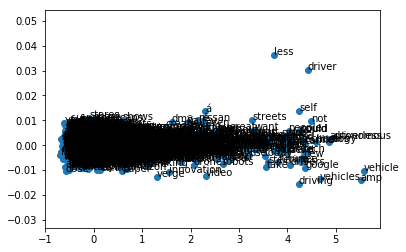

In [31]:
pca = PCA(n_components=10)
result = pca.fit_transform(PCA_AR)
# create a scatter plot of the projection
plt.scatter(result[:, 0], result[:, 9])
words = list(model.wv.vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 9]))
plt.show()

## Split into train and test datasets

In [32]:
#Now the training set and test set need to be defined. 
#The goal is to predict the sentiment value from the text.
x_train, x_test, y_train, y_test = train_test_split(np.array(senti.text),
                                                    np.array(senti.sentiment), test_size=0.2)

In [33]:
print(x_train)

['mtgooglecar tesla moves ahead google race build self driving cars financial times technews sayfie'
 'gov mandate self driving cars protection manual driving prohibited'
 'would anyone need self driving car' ... 'wtf self driving cars yet'
 'solution parents drive kids driverless cars'
 'soylent self driving cars thinking satire fascism campaign video australia nz']


In [34]:
print(y_train)

['3' '3' '2' ... '3' '3' '3']


In [35]:
print(x_test)

['u driverless vehicle effort gets additional support industry partners plan commit total'
 'watch super cool video self driving car'
 'another important step forward self driving cars gt google designing one scratch'
 ...
 'hey check sharknado arduino powered autonomous vehicle gps magnetometer ultrasonic'
 'students learning self driving car' 'not self driving automobiles yet']


In [36]:
print(y_test)

['3' '5' '3' ... '3' '3' '4']


## Tokenizing and Splitting into Training and Test Datasets

In [37]:
# Create Fit a Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

In [38]:
#Let's print the word counts
print(tokenizer.word_counts)

OrderedDict([('mtgooglecar', 1), ('tesla', 68), ('moves', 2), ('ahead', 17), ('google', 2342), ('race', 20), ('build', 56), ('self', 3243), ('driving', 3422), ('cars', 2553), ('financial', 2), ('times', 9), ('technews', 3), ('sayfie', 10), ('gov', 13), ('mandate', 1), ('protection', 1), ('manual', 10), ('prohibited', 1), ('would', 234), ('anyone', 22), ('need', 168), ('car', 2945), ('love', 56), ('company', 19), ('stands', 1), ('world', 81), ('um', 5), ('driverless', 1499), ('vehicle', 158), ('effort', 6), ('gets', 45), ('additional', 1), ('support', 8), ('associated', 3), ('press', 8), ('ann', 18), ('arbor', 17), ('rt', 178), ('bmw', 22), ('unveils', 49), ('galaxy', 1), ('gear', 5), ('smartwatch', 1), ('app', 13), ('fbi', 16), ('warns', 7), ('could', 193), ('used', 20), ('lethal', 7), ('weapons', 7), ('regular', 2), ('not', 584), ('right', 72), ('angelinos', 1), ('avoiding', 2), ('traffic', 85), ('science', 13), ('really', 86), ('solve', 19), ('maybe', 34), ('almost', 30), ('smart', 2

In [39]:
#Let's print the word index
print(tokenizer.word_index)

{'driving': 1, 'self': 2, 'car': 3, 'cars': 4, 'google': 5, 'driverless': 6, 'not': 7, 'autonomous': 8, 'future': 9, 'saw': 10, 'would': 11, 'like': 12, 'no': 13, 'one': 14, 'drive': 15, 'could': 16, 'get': 17, 'new': 18, 'rt': 19, 'california': 20, 'need': 21, 'via': 22, 'see': 23, 'uber': 24, 'first': 25, 'vehicle': 26, 'driver': 27, 'think': 28, 'want': 29, 'today': 30, 'amp': 31, 'wheel': 32, 'road': 33, 'vehicles': 34, 'people': 35, 'going': 36, 'make': 37, 'technology': 38, 'steering': 39, 'tech': 40, 'time': 41, 'cool': 42, 'less': 43, 'way': 44, 'wait': 45, 'drivers': 46, 'go': 47, 'take': 48, 'next': 49, 'says': 50, 'us': 51, 'look': 52, 'test': 53, 'really': 54, 'soon': 55, 'traffic': 56, 'streets': 57, 'world': 58, 'city': 59, 'years': 60, 'roads': 61, 'still': 62, 'around': 63, 'ready': 64, 'work': 65, 'legal': 66, 'right': 67, 'good': 68, 'ride': 69, 'audi': 70, 'tesla': 71, 'great': 72, 'much': 73, 'know': 74, 'view': 75, 'already': 76, 'street': 77, 'day': 78, 'auto': 79

In [40]:
#For future use, let's print the length of the word index
print(len(tokenizer.word_index))

7641


In [41]:
# integer encode sequences
encoded_train = tokenizer.texts_to_sequences(x_train)

In [42]:
encoded_train

[[3351, 71, 2309, 388, 5, 329, 88, 2, 1, 4, 2310, 692, 1773, 628],
 [498, 3352, 2, 1, 4, 3353, 629, 1, 3354],
 [11, 294, 21, 2, 1, 3],
 [5, 2, 1, 3, 89, 344, 3355, 58],
 [1197, 6, 26, 1019, 116, 3356, 787, 1774, 788, 366, 389, 1019],
 [19, 295, 105, 2, 1, 4, 3357, 1198, 3358, 499],
 [409, 889, 6, 4, 16, 330, 890, 891, 2311, 4, 7, 67],
 [3359, 2312, 56, 500, 2, 1, 4, 54, 345, 171],
 [203, 2, 1, 4, 239, 1434],
 [5, 2, 1, 3, 693, 694, 892, 145, 789, 893, 367, 2313],
 [1020,
  466,
  71,
  1775,
  5,
  139,
  296,
  2,
  1,
  4,
  501,
  1021,
  440,
  3360,
  1199,
  894,
  390],
 [3361, 10, 5, 3, 3362],
 [65, 5, 1776, 3363, 3364, 502, 90, 695, 331, 2, 1, 3, 3365, 3366],
 [6, 4, 7, 258, 1022, 7, 29, 274, 2314, 259, 3367, 3368],
 [6, 4, 503, 2315, 2316, 575, 696, 275],
 [3369, 2317, 7, 2, 1435, 12, 2318, 576, 2, 1, 4],
 [5, 105, 2, 1, 3, 82, 2319],
 [630, 15, 1777, 2, 1, 3, 1778, 2320, 1436],
 [184, 2, 1, 4, 631, 2, 1, 1779, 346],
 [276, 2, 1, 3, 29, 15, 51, 3370, 467, 3371],
 [24, 35, 12,

In [43]:
# max sentence length
max_length = max([len(s.split()) for s in x_train])

In [44]:
# pad teaining sequences with 0 values
Xtrain = pad_sequences(encoded_train, maxlen=max_length, padding='post')

In [45]:
#one-hot-encode the training labels
from keras.utils import to_categorical
y_encoded_train = to_categorical(y_train)
print(y_encoded_train)

[[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


In [46]:
# integer encode sequences
encoded_test = tokenizer.texts_to_sequences(x_test)

In [47]:
# pad teaining sequences with 0 values
Xtest = pad_sequences(encoded_test, maxlen=max_length, padding='post')

In [48]:
#one-hot-encode the test labels
from keras.utils import to_categorical
y_encoded_test = to_categorical(y_test)
print(y_encoded_test)

[[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]


## Using the Word2Vec embeddings as input into the CNN

In [49]:
#Code taken from and modified from “Using pre-trained word embeddings in a Keras model” (https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html)
file = open('embedding_word2vec.txt','r')
lines = file.readlines()[1:] #Added the [1:] to skip the first line for Word2Vec files
file.close()
embeddings_index = dict()
for line in lines:
    parts = line.split()
    word = parts[0]
    embeddings_index[word] = asarray(parts[1:], dtype='float32')

In [50]:
embedding_dimension = 100
word_index = tokenizer.word_index

In [51]:
#Code taken from and modified from “Using pre-trained word embeddings in a Keras model” (https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html)
# create a weight matrix for the Embedding layer 
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dimension))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
    # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [52]:
embedding_matrix.shape

(7642, 100)

In [53]:
print(embedding_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.36608389 -0.43329528 -0.09236878 ...  0.67162067 -0.82257426
  -0.0535916 ]
 [ 0.33871329 -0.42596978 -0.04697002 ...  0.65827227 -0.82390547
  -0.06657765]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [55]:
#Loading the embedding matrix into the Embeddings layer
embedding_layer = Embedding(embedding_matrix.shape[0], 100, weights=[embedding_matrix], input_length=max_length, trainable=False)

In [72]:
model2 = Sequential()
model2.add(embedding_layer)
model2.add(Conv1D(150, 3, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(150, 3, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(150, 3, activation='relu'))
model2.add(MaxPooling1D(pool_size=1)) 
model2.add(Flatten())
model2.add(Dropout(0.8)) 
model2.add(Dense(150, kernel_regularizer=regularizers.l2(0.1), activation='relu')) 
model2.add(Dense(6, activation='softmax'))
print(model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 21, 100)           764200    
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 19, 150)           45150     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 9, 150)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 7, 150)            67650     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 3, 150)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 1, 150)            67650     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 1, 150)            0         
__________

In [73]:
#Divide the training dataset into training and validation datasets
x_val_data = Xtrain[:2000]
partial_x_train = Xtrain[2000:]
y_val_data = y_encoded_train[:2000]
partial_y_train = y_encoded_train[2000:]
# Compile 
model2.compile(loss='categorical_crossentropy', optimizer='Adagrad', metrics=['accuracy'])
# Fit #epochs=100
history = model2.fit(partial_x_train, partial_y_train, epochs=100, validation_data=(x_val_data, y_val_data), verbose=2)
# Evaluate
results = model2.evaluate(Xtest, y_encoded_test, verbose=2)
print(results)
print('Test Accuracy: %f' % (results[1]*100))

Train on 3554 samples, validate on 2000 samples
Epoch 1/100
 - 1s - loss: 3.1235 - acc: 0.5931 - val_loss: 1.3543 - val_acc: 0.6035
Epoch 2/100
 - 1s - loss: 1.2460 - acc: 0.6083 - val_loss: 1.1984 - val_acc: 0.6035
Epoch 3/100
 - 1s - loss: 1.1711 - acc: 0.6083 - val_loss: 1.1457 - val_acc: 0.6035
Epoch 4/100
 - 1s - loss: 1.1397 - acc: 0.6083 - val_loss: 1.1732 - val_acc: 0.6035
Epoch 5/100
 - 1s - loss: 1.1396 - acc: 0.6083 - val_loss: 1.1456 - val_acc: 0.6035
Epoch 6/100
 - 1s - loss: 1.1251 - acc: 0.6083 - val_loss: 1.1220 - val_acc: 0.6035
Epoch 7/100
 - 1s - loss: 1.1194 - acc: 0.6083 - val_loss: 1.1250 - val_acc: 0.6035
Epoch 8/100
 - 1s - loss: 1.1195 - acc: 0.6083 - val_loss: 1.1163 - val_acc: 0.6035
Epoch 9/100
 - 1s - loss: 1.1112 - acc: 0.6083 - val_loss: 1.1165 - val_acc: 0.6035
Epoch 10/100
 - 1s - loss: 1.1115 - acc: 0.6083 - val_loss: 1.1154 - val_acc: 0.6035
Epoch 11/100
 - 1s - loss: 1.1121 - acc: 0.6083 - val_loss: 1.1210 - val_acc: 0.6035
Epoch 12/100
 - 1s - loss:

Epoch 97/100
 - 1s - loss: 1.0481 - acc: 0.6111 - val_loss: 1.1201 - val_acc: 0.5985
Epoch 98/100
 - 1s - loss: 1.0452 - acc: 0.6148 - val_loss: 1.1409 - val_acc: 0.6020
Epoch 99/100
 - 1s - loss: 1.0456 - acc: 0.6151 - val_loss: 1.1284 - val_acc: 0.5995
Epoch 100/100
 - 1s - loss: 1.0447 - acc: 0.6162 - val_loss: 1.1318 - val_acc: 0.5890
[1.0855792633400623, 0.6141108712590453]
Test Accuracy: 61.411087


In [64]:
# serialize model to JSON
model_json = model2.to_json()
with open("model_new.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model2.save_weights("model_new.h5")
print("Saved model to disk")

Saved model to disk


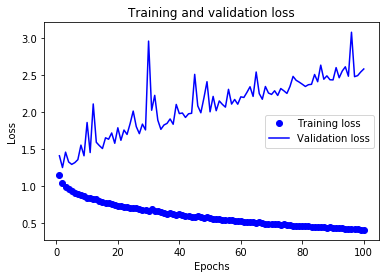

In [65]:
#Plotting training and validation loss
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

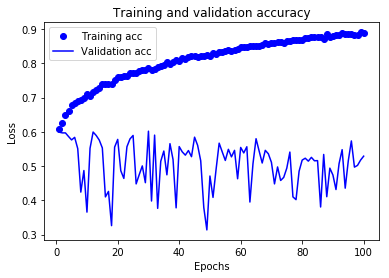

In [66]:
#Plotting training and validation accuracy

plt.clf()   # clear figure

acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [67]:
# load json and create model
json_file = open('model_new.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_new.h5")
print("Loaded model from disk")
#Defining labels to display the predicted label in a more human-friendly way
labels = [[''], ['Very negative'], ['Slightly negative'], ['Neutral'], ['Slightly positive'], ['Very positive']]
#Giving the model an experimental tweet.
exp_tests = ['Unnecessary waste of time. Creepy and freaky. Not worth it.']
encoded_exp = tokenizer.texts_to_sequences(exp_tests)
Xexp = pad_sequences(encoded_exp, maxlen=max_length, padding='post')
pred = model2.predict_classes(Xexp)
print(pred)
print(labels[pred[0]])

Loaded model from disk
[3]
['Neutral']


In [ ]:
#Giving the model an experimental tweet.
exp_tests = ['Whoever did this completely wasted their time. #sadmacface']
encoded_exp = tokenizer.texts_to_sequences(exp_tests)
Xexp = pad_sequences(encoded_exp, maxlen=max_length, padding='post')

pred = model2.predict_classes(Xexp)
print(pred)
print(labels[pred[0]])

In [68]:
#Giving the model an experimental tweet.
exp_tests = ['GENIUS! AWESOME! Who thought of this? They are amazing people.']
encoded_exp = tokenizer.texts_to_sequences(exp_tests)
Xexp = pad_sequences(encoded_exp, maxlen=max_length, padding='post')

pred = model2.predict_classes(Xexp)
print(pred)
print(labels[pred[0]])

[3]
['Neutral']


In [98]:
#Giving the model an experimental tweet.
exp_tests = ['Self-driving cars are murderers that kill people. I HATE them, they suck, and I am NOT driving them.']
encoded_exp = tokenizer.texts_to_sequences(exp_tests)
Xexp = pad_sequences(encoded_exp, maxlen=max_length, padding='post')

pred = model2.predict_classes(Xexp)
print(pred)
print(labels[pred[0]])

[4]
['Slightly positive']


## Using pre-trained GloVe embeddings

In [92]:
#Code taken from and modified from “Using pre-trained word embeddings in a Keras model” (https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html)
file = open('./glove.twitter.27B.100d.txt','r', encoding="utf8")
#This GloVe dataset is made available under the Public Domain Dedication and License v1.0 whose full text 
#can be found at: http://www.opendatacommons.org/licenses/pddl/1.0/
lines = file.readlines()
file.close()
embeddings_index = dict()
for line in lines:
    parts = line.split()
    word = parts[0]
    embeddings_index[word] = asarray(parts[1:], dtype='float32')

In [93]:
embedding_dimension = 100
word_index = tokenizer.word_index

In [94]:
#Code taken from and modified from “Using pre-trained word embeddings in a Keras model” (https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html)
# create a weight matrix for the Embedding layer
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dimension))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
    # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [95]:
embedding_matrix.shape

(7621, 100)

In [96]:
print(embedding_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.36298001 -0.74724001  0.36847001 ... -0.49410999 -0.62857002
  -0.13224   ]
 [-0.16382    -0.54026997 -0.19439    ... -0.17475     0.66162002
   0.012135  ]
 ...
 [ 1.01230001 -1.36010003 -0.51077002 ... -0.22409999  0.24276
   0.33618   ]
 [-0.076581   -0.45701     0.67857999 ...  0.54547    -0.59368002
   0.0081266 ]
 [ 0.026394    0.56664997 -0.32798001 ...  0.75559002  0.064899
  -0.60518003]]


In [64]:
#Loading the embedding matrix into the Embeddings layer
embedding_layer = Embedding(embedding_matrix.shape[0], 100, weights=[embedding_matrix], input_length=max_length, trainable=False)

In [97]:
from keras import regularizers
model3 = Sequential()
model3.add(embedding_layer)
model3.add(Conv1D(150, 3, activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Conv1D(150, 3, activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Conv1D(150, 3, activation='relu'))
model3.add(MaxPooling1D(pool_size=1)) 
model3.add(Flatten())
model3.add(Dropout(0.8)) 
model3.add(Dense(150, kernel_regularizer=regularizers.l2(0.1), activation='relu'))
model3.add(Dense(6, activation='softmax'))
print(model3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 26, 100)           762100    
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 24, 150)           45150     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 12, 150)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 10, 150)           67650     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 5, 150)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 3, 150)            67650     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 3, 150)            0         
__________

In [98]:
#Divide the training dataset into training and validation datasets
x_val = Xtrain[:2000]
partial_x_train = Xtrain[2000:]
y_val = y_encoded_train[:2000]
partial_y_train = y_encoded_train[2000:]
# compile 
model3.compile(loss='categorical_crossentropy', optimizer='Adagrad', metrics=['accuracy'])
# fit
print()
history = model3.fit(partial_x_train, partial_y_train, epochs=100, validation_data=(x_val, y_val), verbose=2)
# evaluate
results = model3.evaluate(Xtest, y_encoded_test, verbose=2)
print(results)
print('Test Accuracy: %f' % (results[1]*100))


Train on 3554 samples, validate on 2000 samples
Epoch 1/100
 - 2s - loss: 2.9631 - acc: 0.5881 - val_loss: 1.2039 - val_acc: 0.6265
Epoch 2/100
 - 1s - loss: 1.1972 - acc: 0.6050 - val_loss: 1.1797 - val_acc: 0.6265
Epoch 3/100
 - 1s - loss: 1.1562 - acc: 0.6050 - val_loss: 1.1778 - val_acc: 0.6265
Epoch 4/100
 - 1s - loss: 1.1524 - acc: 0.6050 - val_loss: 1.0905 - val_acc: 0.6265
Epoch 5/100
 - 1s - loss: 1.1389 - acc: 0.6050 - val_loss: 1.1056 - val_acc: 0.6265
Epoch 6/100
 - 1s - loss: 1.1342 - acc: 0.6050 - val_loss: 1.1520 - val_acc: 0.6265
Epoch 7/100
 - 1s - loss: 1.1329 - acc: 0.6050 - val_loss: 1.0818 - val_acc: 0.6265
Epoch 8/100
 - 1s - loss: 1.1274 - acc: 0.6050 - val_loss: 1.1258 - val_acc: 0.6265
Epoch 9/100
 - 1s - loss: 1.1244 - acc: 0.6050 - val_loss: 1.0728 - val_acc: 0.6265
Epoch 10/100
 - 1s - loss: 1.1233 - acc: 0.6050 - val_loss: 1.0911 - val_acc: 0.6265
Epoch 11/100
 - 1s - loss: 1.1240 - acc: 0.6050 - val_loss: 1.0758 - val_acc: 0.6265
Epoch 12/100
 - 1s - loss

Epoch 97/100
 - 2s - loss: 1.0547 - acc: 0.6030 - val_loss: 1.0937 - val_acc: 0.6225
Epoch 98/100
 - 2s - loss: 1.0589 - acc: 0.6033 - val_loss: 1.0957 - val_acc: 0.6265
Epoch 99/100
 - 2s - loss: 1.0539 - acc: 0.6058 - val_loss: 1.0889 - val_acc: 0.6265
Epoch 100/100
 - 2s - loss: 1.0560 - acc: 0.6072 - val_loss: 1.0859 - val_acc: 0.6265
[1.1279881966036802, 0.6061915048941852]
Test Accuracy: 60.619150


In [99]:
# serialize model to JSON
model_json = model3.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model3.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


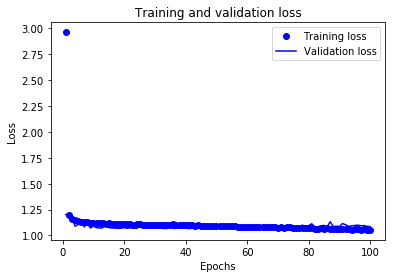

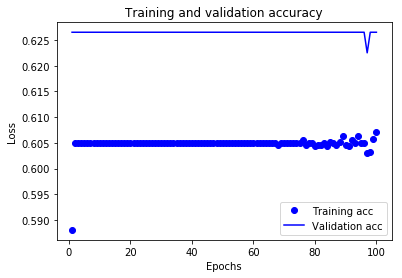

In [100]:
#Plotting training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
plt.clf()   # clear figure

#Plotting training and validation accuracy
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [101]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
#Defining labels to display the predicted label in a more human-friendly way
labels = [[''], ['Very negative'], ['Slightly negative'], ['Neutral'], ['Slightly positive'], ['Very positive']]
#Giving the model an experimental tweet.
exp_tests = ['Unnecessary waste of time. Creepy and freaky. Not worth it.']
encoded_exp = tokenizer.texts_to_sequences(exp_tests)
Xexp = pad_sequences(encoded_exp, maxlen=max_length, padding='post')

pred = model3.predict_classes(Xexp)
print(pred)
print(labels[pred[0]])

Loaded model from disk
[3]
['Neutral']


In [105]:
#Giving the model an experimental tweet.
exp_tests = ['GREAT. Great. Awesome. GENIUS. Hello. GREATEST THING EVER']
encoded_exp = tokenizer.texts_to_sequences(exp_tests)
Xexp = pad_sequences(encoded_exp, maxlen=max_length, padding='post')

pred = model3.predict_classes(Xexp)
print(pred)
print(labels[pred[0]])

[3]
['Neutral']


In [75]:
#Giving the model an experimental tweet.
exp_tests = ['Whoever did this completely wasted their time. #sadmacface']
encoded_exp = tokenizer.texts_to_sequences(exp_tests)
Xexp = pad_sequences(encoded_exp, maxlen=max_length, padding='post')

pred = model3.predict_classes(Xexp)
print(pred)
print(labels[pred[0]])

[4]
['Slightly positive']


In [76]:
#Giving the model an experimental tweet.
exp_tests = ['GENIUS! AWESOME! Who thought of this? They are amazing people.']
encoded_exp = tokenizer.texts_to_sequences(exp_tests)
Xexp = pad_sequences(encoded_exp, maxlen=max_length, padding='post')

pred = model3.predict_classes(Xexp)
print(pred)
print(labels[pred[0]])

[4]
['Slightly positive']


In [77]:
#Giving the model an experimental tweet.
exp_tests = ['Self-driving cars are murderers that kill people. I HATE them, they suck, and I am NOT driving them.']
encoded_exp = tokenizer.texts_to_sequences(exp_tests)
Xexp = pad_sequences(encoded_exp, maxlen=max_length, padding='post')

pred = model3.predict_classes(Xexp)
print(pred)
print(labels[pred[0]])

[2]
['Slightly negative']


# Thank you!